<a href="https://colab.research.google.com/github/ProtossDragoon/paper_implementation_and_testing_tf2/blob/main/utils/Qualitative_Evaluation_Realworld_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qualitative Evaluation Realworld Data

- Real World 문제를 풀고자 할 때, 내가 real world 에서 수집하는 데이터셋의 레이블이 존재하지 않는 경우가 있습니다. - 이런 경우에 매번 데이터셋에 레이블링을 해서 사용하기는 현실적으로 불가능할 때가 많습니다. 
- 당연히 lean 하게 우선적으로 해 보아야 하는 방법은 정성적인 결과물 평가입니다. 
- 이를 통해 대략적인 해상도/augmentation 의 방향/모델의 capacity 등 적합성을 빠르게 평가해볼 수 있습니다.

## Author

name : Janghoo Lee <br>
github : https://github.com/ProtossDragoon <br>
contact : dlwkdgn1@naver.com <br>
circle : https://github.com/sju-coml <br>
organization : https://web.deering.co/ <br>
published date : November, 2021


## Related Notebook

[Notebooks](https://github.com/ProtossDragoon/paper_implementation_and_testing_tf2/tree/main/notebooks)


# Environment

In [99]:
# 내장
import os, sys
import time

# 서드파티
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

## Google Drive / Git

In [100]:
#!rm -r /content/gdrive/
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [101]:
class PathManager():
    #FIXME: clean code
    
    def __init__(
        self,
        gdrive_home_dir:str='/content/gdrive/MyDrive',
        workspace_dir_from_home_dir:str='ColabWorkspace',
        data_dir_from_home_dir:str='data',
        git_repo_name:str='paper_implementation_and_testing_tf2',
    ):
        self._set_dirs(
            data_dir_from_home_dir,
            workspace_dir_from_home_dir,
            git_repo_name,
            gdrive_home_dir=gdrive_home_dir,
            )
        self.gcs_mode = False
        self.gcp_initialized = False

    def _set_dirs(self,
        data_dir_from_home_dir,
        workspace_dir_from_home_dir,
        git_repo_name,
        gdrive_home_dir=None,
        gcs_home_dir=None,
    ):
        """경로 관련 모든 클래스 변수의 저장은
        여기서 이루어집니다.
        """
        if gdrive_home_dir:
            assert not gcs_home_dir
            self.gdrive_home_dir = gdrive_home_dir
            self.home_dir = self.gdrive_home_dir
        if gcs_home_dir:
            assert not gdrive_home_dir
            self.gcs_home_dir = gcs_home_dir
            self.home_dir = self.gcs_home_dir
        
        self._cache_data_dir_from_home_dir = data_dir_from_home_dir
        self._cache_workspace_dir_from_home_dir = workspace_dir_from_home_dir
        self._cache_git_repo_name = git_repo_name

        self.ws          = os.path.join(self.home_dir, workspace_dir_from_home_dir)
        self.git_repo_ws = os.path.join(self.ws, git_repo_name)
        self.data_dir    = os.path.join(self.home_dir, data_dir_from_home_dir)
        self.models_dir  = os.path.join(self.git_repo_ws, 'models')

    def init_gcs(
        self,
        gcs_bucket_name:str,
        gcp_project_name:str,
        gcp_project_id:str,
        gcp_region:str,
    ):
        """구글 클라우드 서비스 관련 정보를 저장하고, 
        권한을 인증해 앞으로 사용할 수 있도록 합니다.
        """
        self.gcp_initialized = True
        self.gcp_bucket_name = gcs_bucket_name
        self.gcp_project_name = gcp_project_name
        self.gcp_project_id = gcp_project_id
        self.gcp_region = gcp_region

        # this is always set on Colab, the value is 0 or 1 depending on GPU presence
        _is_colab_backend = 'COLAB_GPU' in os.environ
        if _is_colab_backend:
            if 'google.colab' in sys.modules:
                from google.colab import auth
                auth.authenticate_user()
                os.environ['GOOGLE_CLOUD_PROJECT'] = self.gcp_project_id      

    def set_to_gcs_mode(self,
        gcs_mode=True
    ):
        """실행 모드를 gcs mode 로 변경하고, 
        멤버 변수에 저장된 모든 경로를 변경합니다.
        """
        if not self.gcp_initialized:
            raise NotImplementedError('init_gcs() 을 먼저 실행하세요.')
        self.gcs_mode = gcs_mode
        if self.gcs_mode:
            self._set_dirs(
                self._cache_data_dir_from_home_dir,
                self._cache_workspace_dir_from_home_dir,
                self._cache_git_repo_name,
                gcs_home_dir=os.path.join('gs://', self.gcp_bucket_name)
            )
        else:
            self._set_dirs(
                self._cache_data_dir_from_home_dir,
                self._cache_workspace_dir_from_home_dir,
                self._cache_git_repo_name,
                gdrive_home_dir=self.gdrive_home_dir
            )

paths = PathManager()

## Perpare Data and Model

- 정성적(qualitative) 으로 평가할 데이터셋이 GDrie 에 저장되어 있는 상황입니다.
- 모델이 GCP 에 저장되어 있는 상황입니다.

### Data

In [102]:
TARGET_DATA_DIR_POSTFIX = 'rosbag/rosbag_image_no_pc_river_cloudy' #@param {type:"string"}
TARGET_DATA_DIR = os.path.join(paths.data_dir, TARGET_DATA_DIR_POSTFIX)

/content/gdrive/MyDrive/data/rosbag/rosbag_image_no_pc_river_cloudy


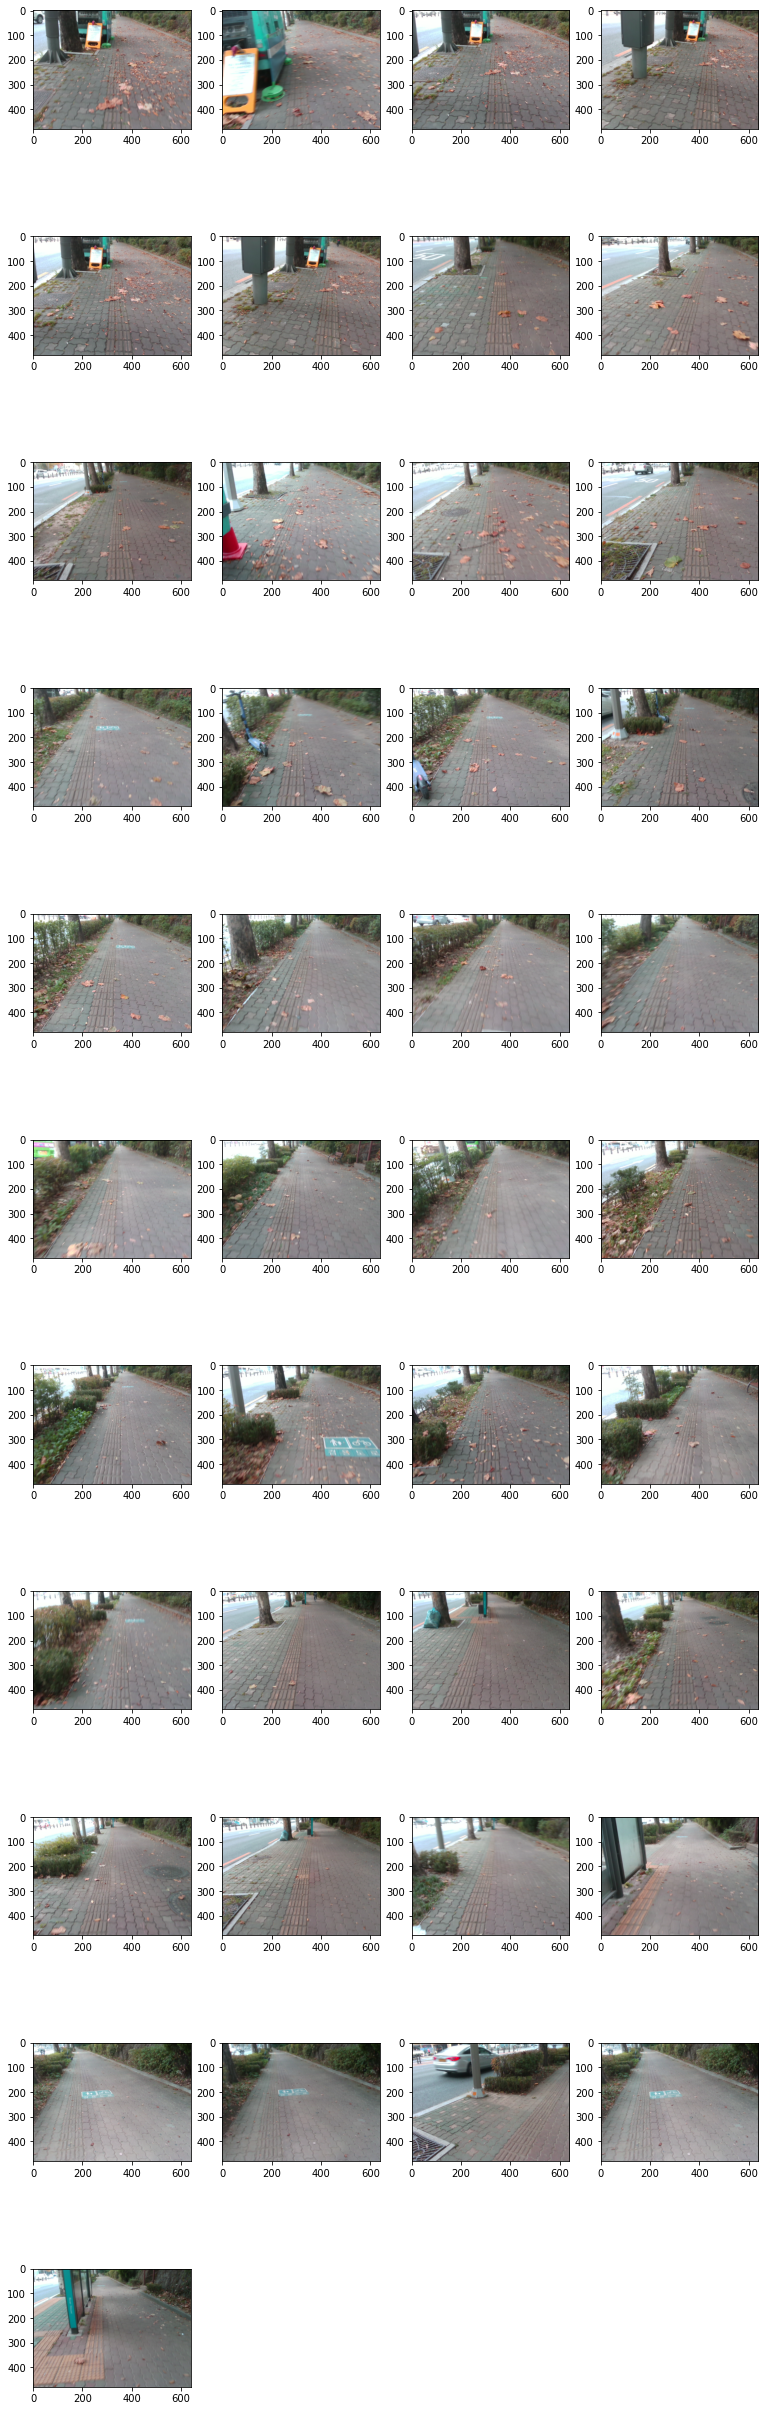

In [103]:
%cd {TARGET_DATA_DIR}
CONVERT_COLOR_FORMAT = False #@param {type:"boolean"}

im_li = []
for name in os.listdir(TARGET_DATA_DIR):
    im = cv2.imread(name)
    if CONVERT_COLOR_FORMAT:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_li.append(im)

def vis_all(im_li):
    plt.figure(figsize=[13, 4+len(im_li)])
    for idx, im in enumerate(im_li, 1):
        plt.subplot(len(im_li)//4+1, 4, idx)
        plt.imshow(im)

vis_all(im_li)

### Model

In [104]:
USE_GCS = True #@param {type:"boolean"}
if USE_GCS:
    GCP_BUCKET_NAME = "deer-newdolph" #@param {type:"string"}
    GCP_PROJECT_NAME = "newdolph" #@param {type:"string"}
    GCP_PROJECT_ID = "flowing-digit-326103" #@param {type:"string"}
    GCP_REGION = 'us-central1'
    paths.init_gcs(
        GCP_BUCKET_NAME,
        GCP_PROJECT_NAME,
        GCP_PROJECT_ID,
        GCP_REGION,
    )
    paths.set_to_gcs_mode(True)

MODEL_PATH_POSTFIX = 'PEDESTRIAN/SURFACE_MASKING/UNET_MOBILENETV2/b128_9c_224_224_tpu_tfrecord_gcs' #@param {type:"string"}
MODEL_PATH = os.path.join(paths.models_dir, MODEL_PATH_POSTFIX)

print('savedmodel {} was selected'.format(MODEL_PATH))
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

savedmodel gs://deer-newdolph/ColabWorkspace/paper_implementation_and_testing_tf2/models/PEDESTRIAN/SURFACE_MASKING/UNET_MOBILENETV2/b128_9c_224_224_tpu_tfrecord_gcs was selected


## Evaluate

다양한 해상도로 평가해 봅니다.

In [105]:
def mask_to_rgb(mask, interested_classid_to_rgb=None):
    if len(mask.shape) == 2: # [h, w]
        # grayscale input
        return mask
    elif len(mask.shape) == 3: # [h, w, c]
        # normal input
        pass
    else:
        # abnormal input
        raise NotImplementedError

    n_ch = mask.shape[-1]
    # print('Number of channel : {}'.format(n_ch))
    if n_ch == 1:
        print('Binary segmentation mask detected.')
        return mask.squeeze()

    idx = np.argmax(mask, axis=-1).squeeze() # [h, w]
    ret = np.zeros([mask.shape[0], mask.shape[1], 3], dtype=np.uint8)
    masking = np.zeros([mask.shape[0], mask.shape[1]], dtype=np.uint8)

    if interested_classid_to_rgb is None:
        # n color generation
        import colorsys
        HSV_tuples = [(x*1.0/n_ch, 0.5, 0.5) for x in range(n_ch)]
        RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
        for i, color in enumerate(RGB_tuples):
            color_masking = np.ma.masked_where(idx == i, masking).mask
            color = (np.array(color) * 255).astype(np.uint8)
            ret[color_masking] = color
    else:
        # use interested_classid_to_rgb dictionary
        for i, (_, color) in enumerate(interested_classid_to_rgb.items()):

            # select color
            np_color = np.array(color)
            if len(np_color.shape) == 2: # e.g. (x, 3)
                if np_color.shape[0] == 1:
                    # single color
                    color = np_color[0]
                else:
                    # multiple color
                    color = np_color[0]
            else: # e.g. (3,)
                # single color
                color = np_color

            color_masking = np.ma.masked_where(idx == i, masking).mask
            ret[color_masking] = color

    assert ret.shape[-1] == 3
    return ret

In [ ]:
def simple_norm(im):
    im = im.astype(np.float32)
    im /= 125.
    im -= 1.
    return im

def inference(
    model,
    im_li,
    inf_w:int=None, 
    inf_h:int=None
)->list:

    res_li = []
    for it, im in enumerate(im_li, 1):

        if inf_w is None:
            inf_w = im.shape[1]
        if inf_h is None:
            inf_h = im.shape[0]

        s = time.time()
        im = cv2.resize(im, (inf_w, inf_h))
        im = simple_norm(im)
        res = model(np.expand_dims(im, axis=0))
        res = np.squeeze(res)
        res_li.append(mask_to_rgb(res))
        e = time.time()
        print(f'iteration {it}, time elapse : {e - s} second')
        
    return res_li

iteration 1, time elapse : 0.9942090511322021 second
iteration 2, time elapse : 0.9855849742889404 second
iteration 3, time elapse : 0.9372704029083252 second
iteration 4, time elapse : 0.9507908821105957 second
iteration 5, time elapse : 0.9492897987365723 second
iteration 6, time elapse : 0.9302268028259277 second
iteration 7, time elapse : 0.9921462535858154 second
iteration 8, time elapse : 0.9899263381958008 second
iteration 9, time elapse : 0.9452712535858154 second
iteration 10, time elapse : 0.9498305320739746 second
iteration 11, time elapse : 0.9657771587371826 second
iteration 12, time elapse : 0.9834582805633545 second
iteration 13, time elapse : 0.9809317588806152 second
iteration 14, time elapse : 0.9560146331787109 second
iteration 15, time elapse : 0.9756643772125244 second
iteration 16, time elapse : 0.963860273361206 second
iteration 17, time elapse : 0.9771106243133545 second
iteration 18, time elapse : 0.9546647071838379 second
iteration 19, time elapse : 0.97142243

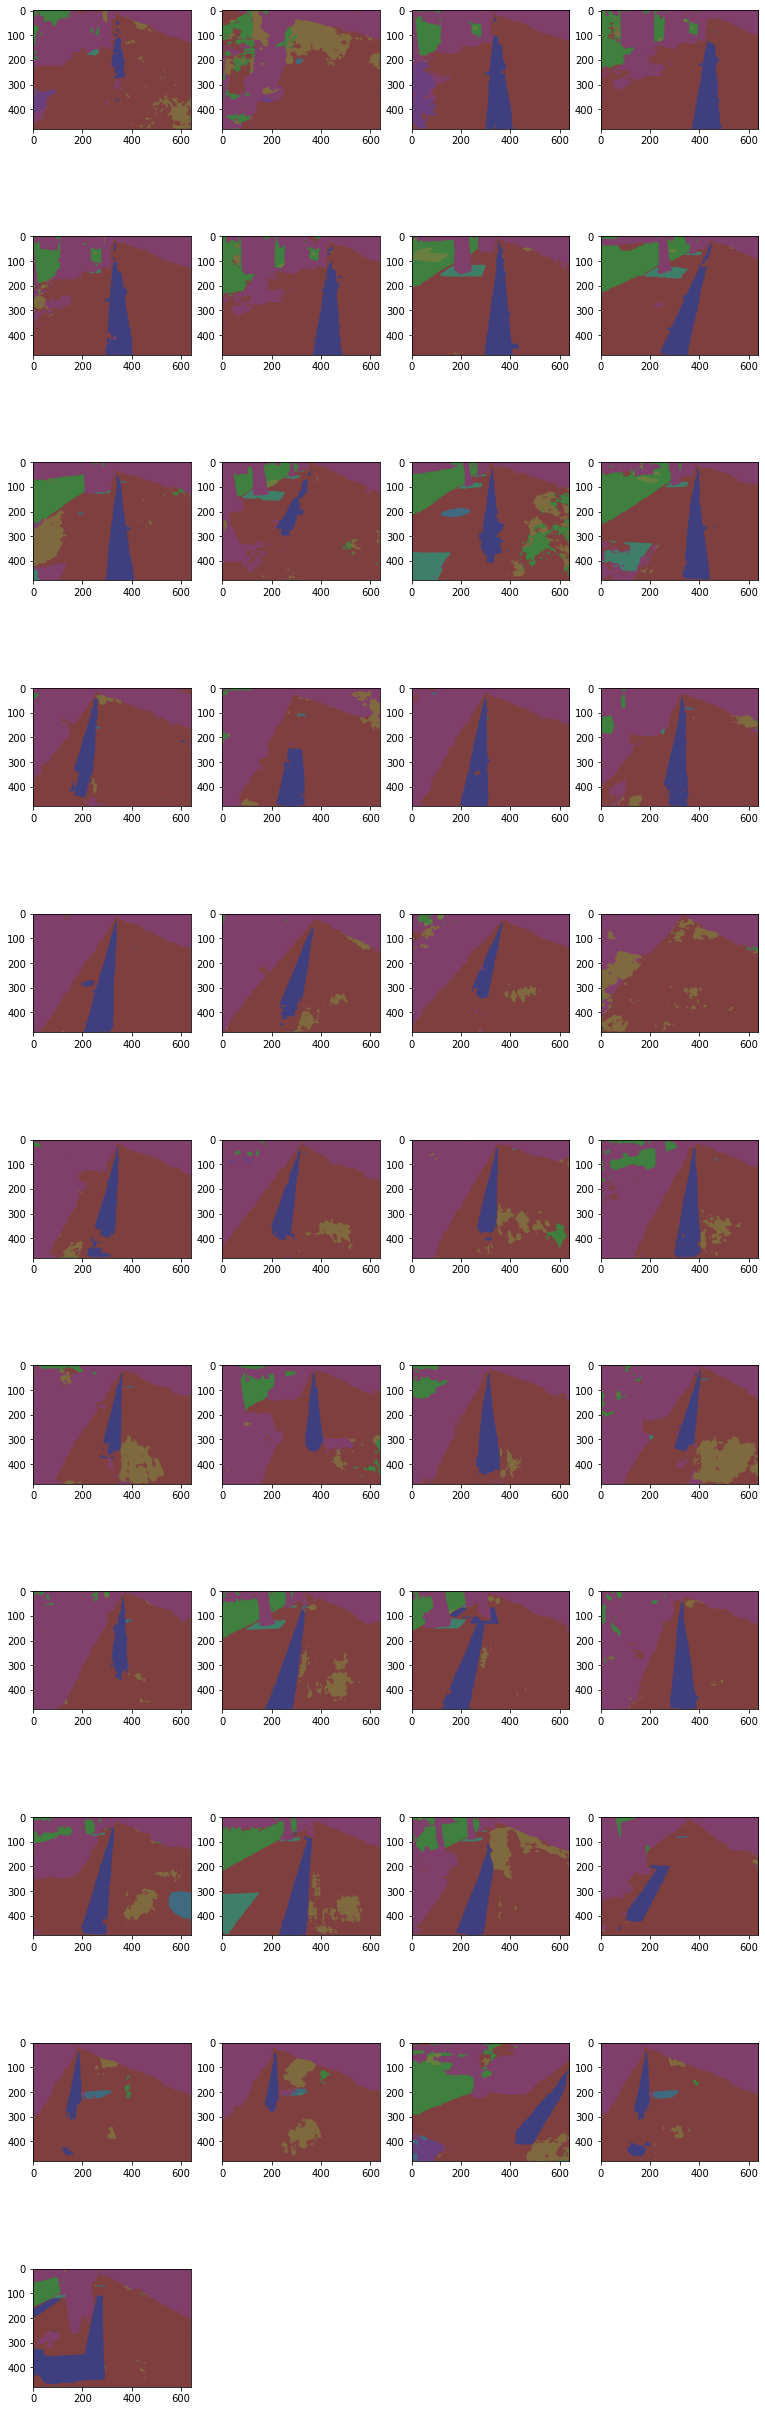

In [107]:
res_li = inference(model, im_li)
vis_all(res_li)

iteration 1, time elapse : 0.47125864028930664 second
iteration 2, time elapse : 0.4285922050476074 second
iteration 3, time elapse : 0.42229270935058594 second
iteration 4, time elapse : 0.4293527603149414 second
iteration 5, time elapse : 0.4253208637237549 second
iteration 6, time elapse : 0.40073275566101074 second
iteration 7, time elapse : 0.4101395606994629 second
iteration 8, time elapse : 0.40414977073669434 second
iteration 9, time elapse : 0.43058109283447266 second
iteration 10, time elapse : 0.41742992401123047 second
iteration 11, time elapse : 0.40601658821105957 second
iteration 12, time elapse : 0.4294321537017822 second
iteration 13, time elapse : 0.4172971248626709 second
iteration 14, time elapse : 0.40161776542663574 second
iteration 15, time elapse : 0.40166139602661133 second
iteration 16, time elapse : 0.3794121742248535 second
iteration 17, time elapse : 0.3820459842681885 second
iteration 18, time elapse : 0.39163923263549805 second
iteration 19, time elapse :

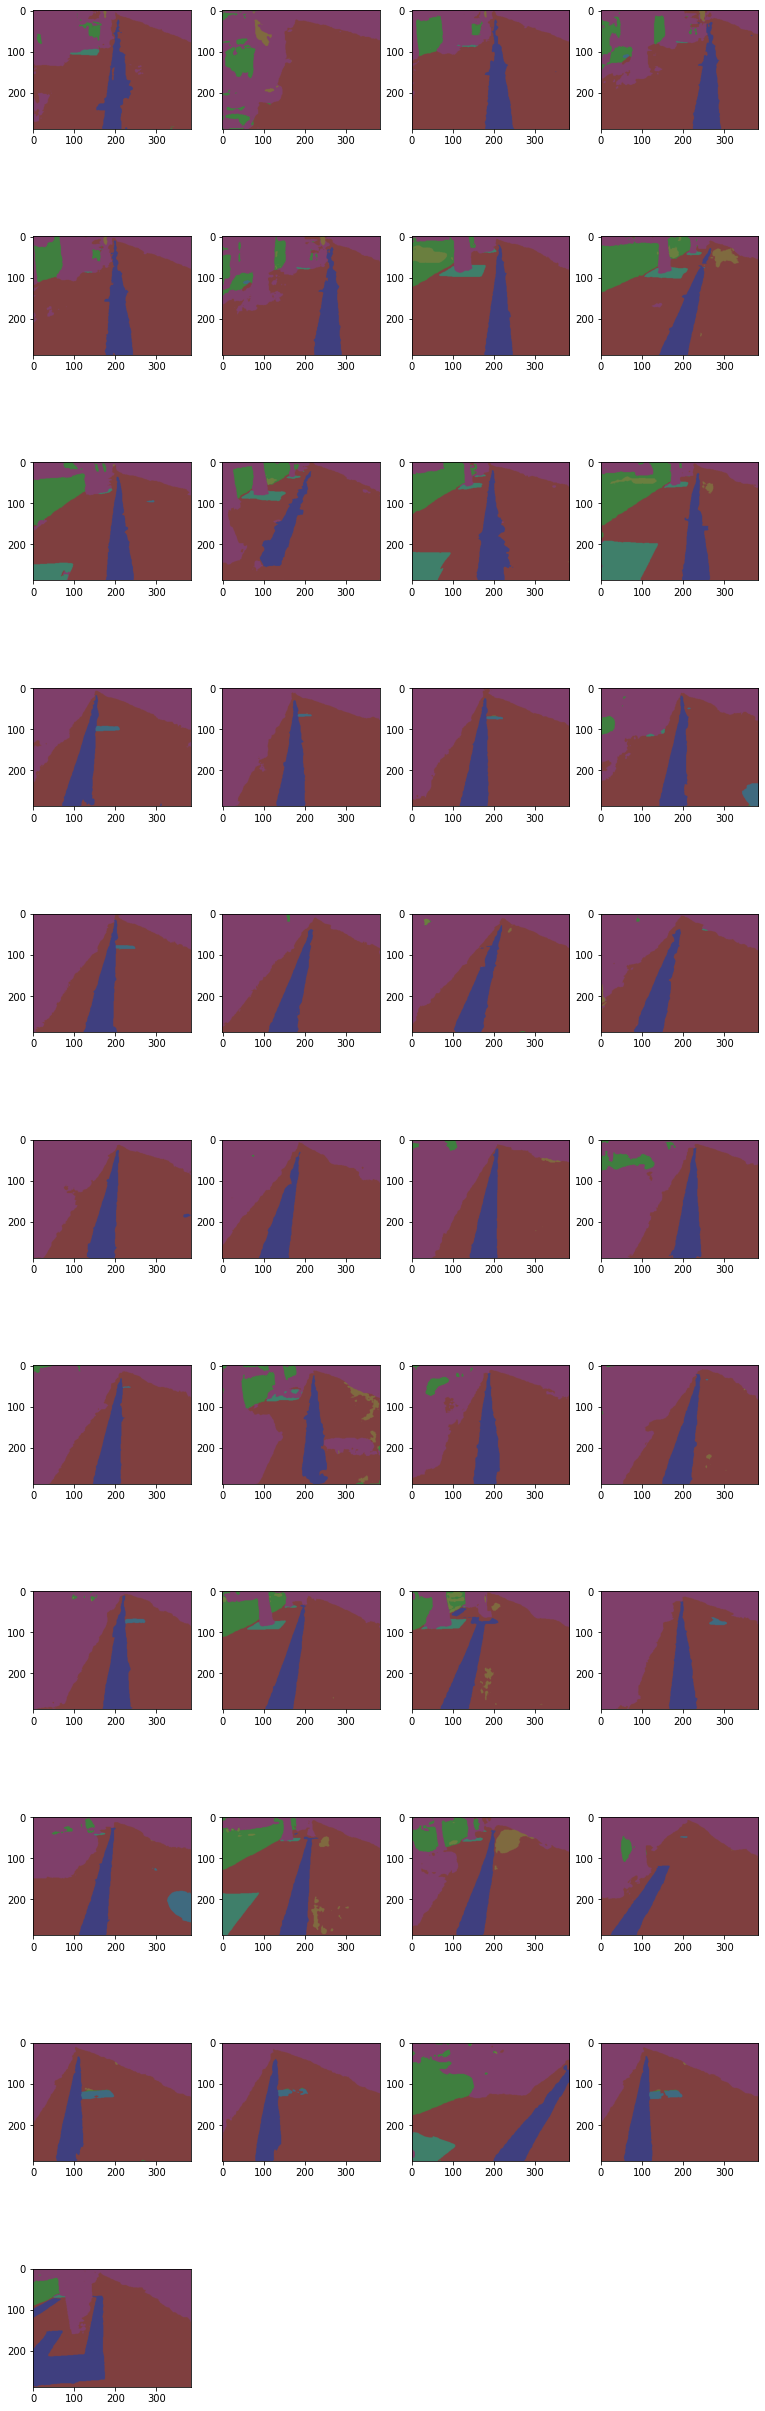

In [108]:
res_li = inference(model, im_li, 384, 288)
vis_all(res_li)

iteration 1, time elapse : 0.384946346282959 second
iteration 2, time elapse : 0.3648979663848877 second
iteration 3, time elapse : 0.37363290786743164 second
iteration 4, time elapse : 0.3746769428253174 second
iteration 5, time elapse : 0.3968057632446289 second
iteration 6, time elapse : 0.42612218856811523 second
iteration 7, time elapse : 0.39409708976745605 second
iteration 8, time elapse : 0.3731999397277832 second
iteration 9, time elapse : 0.3855748176574707 second
iteration 10, time elapse : 0.41004014015197754 second
iteration 11, time elapse : 0.38825535774230957 second
iteration 12, time elapse : 0.39746665954589844 second
iteration 13, time elapse : 0.37877869606018066 second
iteration 14, time elapse : 0.3793621063232422 second
iteration 15, time elapse : 0.3772296905517578 second
iteration 16, time elapse : 0.3836240768432617 second
iteration 17, time elapse : 0.35791754722595215 second
iteration 18, time elapse : 0.38059449195861816 second
iteration 19, time elapse : 0

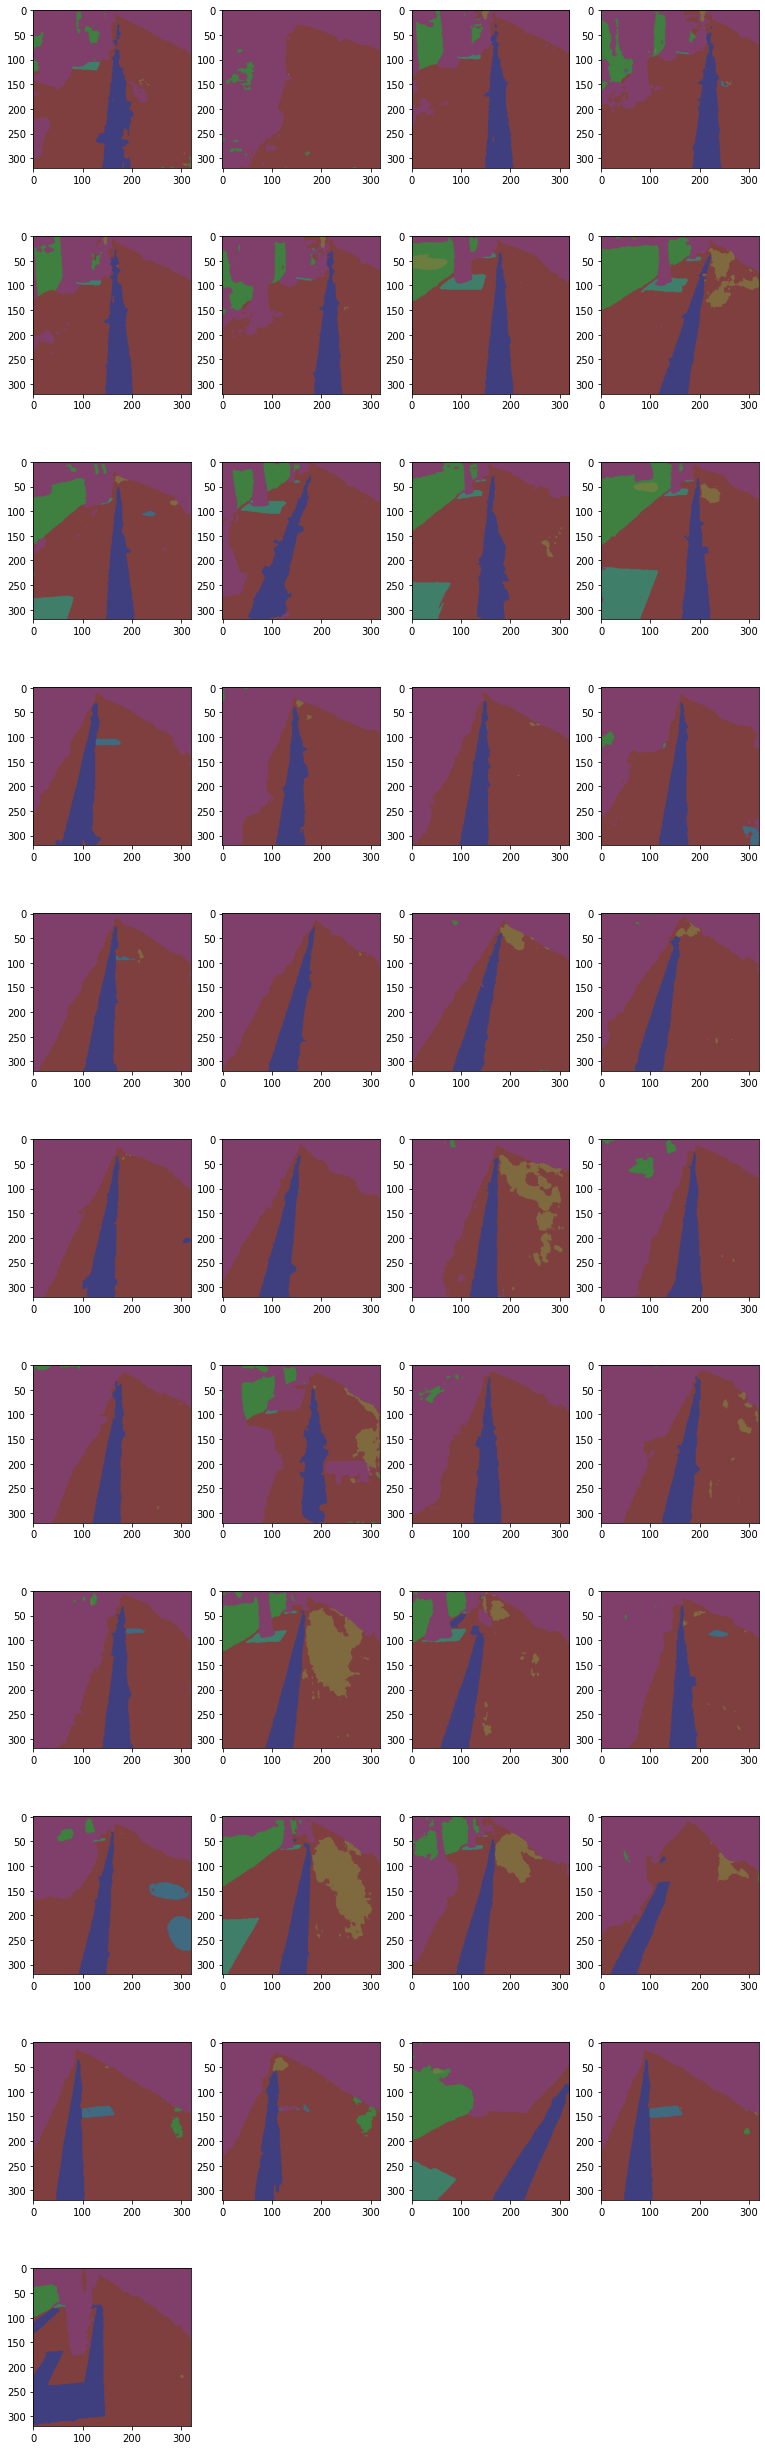

In [109]:
res_li = inference(model, im_li, 320, 320)
vis_all(res_li)

iteration 1, time elapse : 0.2555398941040039 second
iteration 2, time elapse : 0.2289292812347412 second
iteration 3, time elapse : 0.2377643585205078 second
iteration 4, time elapse : 0.22243046760559082 second
iteration 5, time elapse : 0.2254340648651123 second
iteration 6, time elapse : 0.2310774326324463 second
iteration 7, time elapse : 0.25028038024902344 second
iteration 8, time elapse : 0.24793267250061035 second
iteration 9, time elapse : 0.2405250072479248 second
iteration 10, time elapse : 0.22155404090881348 second
iteration 11, time elapse : 0.2350296974182129 second
iteration 12, time elapse : 0.23278021812438965 second
iteration 13, time elapse : 0.2386796474456787 second
iteration 14, time elapse : 0.2440328598022461 second
iteration 15, time elapse : 0.22970986366271973 second
iteration 16, time elapse : 0.22312569618225098 second
iteration 17, time elapse : 0.23171257972717285 second
iteration 18, time elapse : 0.2328958511352539 second
iteration 19, time elapse : 0

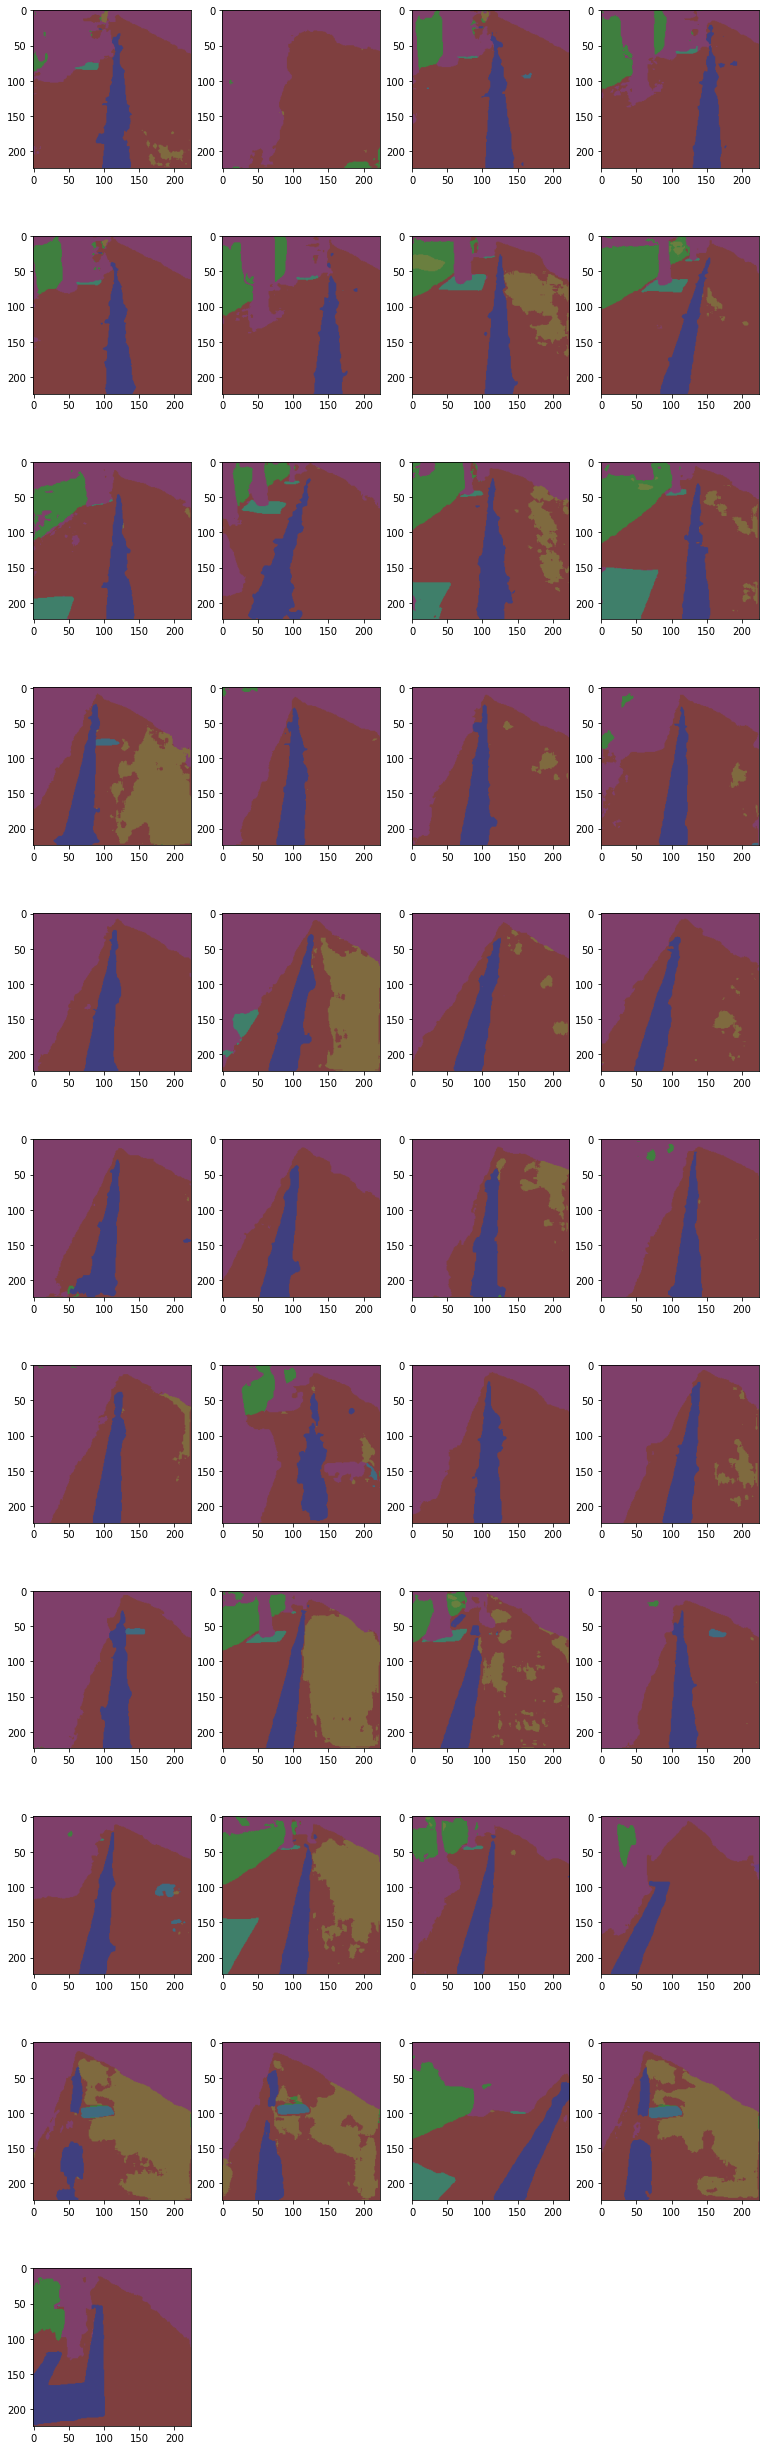

In [110]:
res_li = inference(model, im_li, 224, 224)
vis_all(res_li)